### Data Collection

In [19]:
from bs4 import BeautifulSoup
import requests
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Define the base URL for scraping British Airways reviews from AirlineQuality (Skytrax)
# This will serve as the starting point for constructing paginated URLs

base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'

# Each review page can display up to 100 reviews
page_size = 100

# We'll scrape the first 40 pages of reviews
total_pages = 40

# Initialize an empty list to hold all the review dictionaries
reviews = []

# Step 3: Loop through each review page using pagination
for page in range(total_pages + 1):
    print(f"Scraping page {page} of {total_pages} .........")

    # Construct the URL for the current page
    url = f'{base_url}/page/{page}/?sortby=post_date%3ADesc&pagesize={page_size}'

    # Send an HTTP GET request to the page
    response = requests.get(url)

    # Parse the response HTML using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Step 4: Extract all individual review containers from the HTML
    # Each review is wrapped in an <article> tag with itemprop="review"
    review_containers = soup.find_all('article', {'itemprop': 'review'})

    # Step 5: Loop through each review block and extract data
    for review in review_containers:
        review_dict = {}

        # Extract the title of the review
        title = review.find('h2', {'class': 'text_header'})
        review_dict['title'] = title.get_text(strip=True) if title else None

        # Extract the main review content
        content = review.find('div', {'class': 'text_content', 'itemprop': 'reviewBody'})
        review_dict['content'] = content.get_text(strip=True) if content else None

        # Extract the overall review rating (e.g., 7/10)
        # This is the actual numerical score submitted by the user
        rating_span = review.find('span', itemprop='ratingValue')
        if rating_span:
            try:
                review_dict['rating'] = int(rating_span.get_text(strip=True))
            except ValueError:
                # If the rating is not a valid integer, fall back to None
                review_dict['rating'] = None
        else:
            review_dict['rating'] = None

        # Extract the author's name (if available)
        author = review.find('span', {'itemprop': 'name'})
        review_dict['author'] = author.get_text(strip=True) if author else None

        # Extract the date the review was published
        date = review.find('time', {'itemprop': 'datePublished'})
        if date and date.has_attr('datetime'):
            review_dict['date'] = date['datetime']

        # Check whether the review is marked as "Trip Verified"
        # This helps assess the credibility of the review
        review_dict['verified'] = 'Trip Verified' in content.get_text() if content else False

        # Step 6: Extract additional structured information from the ratings table
        # This includes Aircraft, Route, Seat Type, Comfort, Cabin Staff, etc.
        rows = review.find_all('tr')  # Each <tr> represents a single attribute or rating category

        for row in rows:
            # First <td> is the label (e.g., "Aircraft")
            label_cell = row.find('td', {'class': 'review-rating-header'})
            # Second <td> is the value (e.g., "Boeing 777" or star ratings)
            value_cell = row.find('td', {'class': 'review-value'})

            if label_cell and value_cell:
                # Format the label to be lowercase and underscore-separated for consistency
                key = label_cell.get_text(strip=True).lower().replace(' ', '_')

                # Check if the value includes star icons
                stars = value_cell.find_all('span', {'class': 'star fill'})

                if stars:
                    # If stars are present, count them as a numeric score
                    value = len(stars)
                else:
                    # Otherwise, extract the plain text (e.g., for Aircraft or Route)
                    value = value_cell.get_text(strip=True)

                # Add the field to the current review dictionary
                review_dict[key] = value

        # Step 7: Append the complete review dictionary to the master list
        reviews.append(review_dict)

    # Step 8: Sleep briefly to avoid overwhelming the server (polite scraping)
    time.sleep(2)

Scraping page 0 of 40 .........
Scraping page 1 of 40 .........
Scraping page 2 of 40 .........
Scraping page 3 of 40 .........
Scraping page 4 of 40 .........
Scraping page 5 of 40 .........
Scraping page 6 of 40 .........
Scraping page 7 of 40 .........
Scraping page 8 of 40 .........
Scraping page 9 of 40 .........
Scraping page 10 of 40 .........
Scraping page 11 of 40 .........
Scraping page 12 of 40 .........
Scraping page 13 of 40 .........
Scraping page 14 of 40 .........
Scraping page 15 of 40 .........
Scraping page 16 of 40 .........
Scraping page 17 of 40 .........
Scraping page 18 of 40 .........
Scraping page 19 of 40 .........
Scraping page 20 of 40 .........
Scraping page 21 of 40 .........
Scraping page 22 of 40 .........
Scraping page 23 of 40 .........
Scraping page 24 of 40 .........
Scraping page 25 of 40 .........
Scraping page 26 of 40 .........
Scraping page 27 of 40 .........
Scraping page 28 of 40 .........
Scraping page 29 of 40 .........
Scraping page 30 of 

In [3]:
df = pd.DataFrame(reviews)
df.to_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews_1.csv', index=False)

### Data Preprocessing

In [4]:
reviews_df = pd.read_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews_1.csv',index_col=False)

reviews_df.head()

,title,content,rating,author,date,verified,aircraft,type_of_traveller,seat_type,route,date_flown,recommended
0,“staff were really engaged”,✅Trip Verified| Having had some rough experien...,7.0,A Karlsson,2025-04-16,True,Boeing 788,Solo Leisure,Economy Class,London to Montreal,April 2025,yes
1,"""got it right on this flight""",✅Trip Verified| This comfortable flight was ...,9.0,T Morton,2025-04-16,True,Boeing 777-300,Solo Leisure,First Class,New York to London,April 2025,yes
2,"""exceeded my expectations""",Not Verified| Punta Cana Terminal B check in ...,9.0,Jacqueline Heap,2025-04-15,False,Boeing 777-200,Couple Leisure,Business Class,Punta Cana to London Gatwick,April 2025,yes
3,"""checkin was very rude to us""",✅Trip Verified| The employee at Venice Airpo...,3.0,D Gale,2025-04-13,True,NaN,Couple Leisure,Economy Class,Venice to London,April 2025,no
4,"""forced to check-in carry-ons""","✅Trip Verified| I had only 1 bag with me, a ...",1.0,R Hardin,2025-04-12,True,Airbus A321neo,Solo Leisure,Economy Class,Heathrow to Cairo,April 2025,no


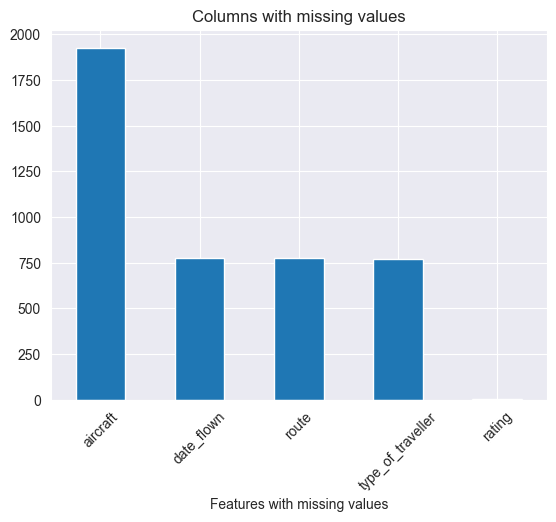

In [5]:
top_missingValue_columns = reviews_df.isnull().sum()\
    .sort_values(ascending=False)\
        .head()

top_missingValue_columns.plot(kind='bar',rot=45)

plt.title('Columns with missing values')

plt.xlabel('Features with missing values')
plt.show()

In [9]:
# I will focus on a basic sentiment analysis (content & rating)
reduced_df = reviews_df.drop(columns=['aircraft','type_of_traveller','route','date_flown'],axis=0)

In [10]:
reduced_df.head()

,title,content,rating,author,date,verified,seat_type,recommended
0,“staff were really engaged”,✅Trip Verified| Having had some rough experien...,7.0,A Karlsson,2025-04-16,True,Economy Class,yes
1,"""got it right on this flight""",✅Trip Verified| This comfortable flight was ...,9.0,T Morton,2025-04-16,True,First Class,yes
2,"""exceeded my expectations""",Not Verified| Punta Cana Terminal B check in ...,9.0,Jacqueline Heap,2025-04-15,False,Business Class,yes
3,"""checkin was very rude to us""",✅Trip Verified| The employee at Venice Airpo...,3.0,D Gale,2025-04-13,True,Economy Class,no
4,"""forced to check-in carry-ons""","✅Trip Verified| I had only 1 bag with me, a ...",1.0,R Hardin,2025-04-12,True,Economy Class,no


In [11]:
def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = text.lower()
    text = re.sub(r"[^\w\s]"," ", text)

    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and word.isalpha()
    ]
    return ' '.join(cleaned_tokens)

reduced_df['cleaned_content'] = reduced_df['content'].apply(clean_text)
reduced_df.head()

,title,content,rating,author,date,verified,seat_type,recommended,cleaned_content
0,“staff were really engaged”,✅Trip Verified| Having had some rough experien...,7.0,A Karlsson,2025-04-16,True,Economy Class,yes,trip verified rough experience ba recent year ...
1,"""got it right on this flight""",✅Trip Verified| This comfortable flight was ...,9.0,T Morton,2025-04-16,True,First Class,yes,trip verified comfortable flight ba best excel...
2,"""exceeded my expectations""",Not Verified| Punta Cana Terminal B check in ...,9.0,Jacqueline Heap,2025-04-15,False,Business Class,yes,verified punta cana terminal b check straightf...
3,"""checkin was very rude to us""",✅Trip Verified| The employee at Venice Airpo...,3.0,D Gale,2025-04-13,True,Economy Class,no,trip verified employee venice airport checkin ...
4,"""forced to check-in carry-ons""","✅Trip Verified| I had only 1 bag with me, a ...",1.0,R Hardin,2025-04-12,True,Economy Class,no,trip verified bag carry trolley everyone one b...


In [16]:
reduced_df

,title,content,rating,author,date,verified,seat_type,recommended,cleaned_content
0,“staff were really engaged”,✅Trip Verified| Having had some rough experien...,7.0,A Karlsson,2025-04-16,True,Economy Class,yes,trip verified rough experience ba recent year ...
1,"""got it right on this flight""",✅Trip Verified| This comfortable flight was ...,9.0,T Morton,2025-04-16,True,First Class,yes,trip verified comfortable flight ba best excel...
2,"""exceeded my expectations""",Not Verified| Punta Cana Terminal B check in ...,9.0,Jacqueline Heap,2025-04-15,False,Business Class,yes,verified punta cana terminal b check straightf...
3,"""checkin was very rude to us""",✅Trip Verified| The employee at Venice Airpo...,3.0,D Gale,2025-04-13,True,Economy Class,no,trip verified employee venice airport checkin ...
4,"""forced to check-in carry-ons""","✅Trip Verified| I had only 1 bag with me, a ...",1.0,R Hardin,2025-04-12,True,Economy Class,no,trip verified bag carry trolley everyone one b...
...,...,...,...,...,...,...,...,...,...
4027,British Airways customer review,Flight from Heathrow to Toronto. Booked emerge...,7.0,C Mcculloch,2012-08-29,False,Economy Class,no,flight heathrow toronto booked emergency exit ...
4028,British Airways customer review,LHR to HAM. Purser addresses all club passenge...,9.0,Nick Berry,2012-08-28,False,Business Class,yes,lhr ham purser address club passenger name boa...
4029,British Airways customer review,My son who had worked for British Airways urge...,5.0,Avril Barclay,2011-10-12,False,Economy Class,yes,son worked british airway urged fly british ai...
4030,British Airways customer review,London City-New York JFK via Shannon on A318 b...,4.0,C Volz,2011-10-11,False,Premium Economy,no,london city new york jfk via shannon really ni...


In [17]:
import random

i = random.randint(0,len(reduced_df))
print(i)
print("Original: ", reduced_df.loc[i,'content'])
print('\n')
print('Cleaned comment: ',reduced_df.loc[i,'cleaned_content'])

2114
Original:  ✅Verified Review|  Hyderabad to London. I have travelled BA numerous times and had very good experiences up until this past week when I was returning from Hyderabad to London from a business trip and was downgraded a cabin. While the downgrade itself was not to so much the problem, the manner in which the BA staff handled the situation and the apparent lack of care or effort exuded was extremely disappointing. I have had previous experiences of being inconvenienced by changes in cabin fair or cancelled flights on other airlines, and in such instances those airlines did a fantastic job of providing alternatives or compensation for my troubles. In this instance with British Airways, I was very surprised to find that the company as a whole seemed to care not at all for my well being or the inconvenience put upon me. When I asked if I could be put on another comparable flight I was shut down and told "no, this is not possible" without any explanation. When I then inquired a

In [18]:
reduced_df.to_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews_2.csv', index=False)

### Sentiment

In [59]:
vader_df = pd.read_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews_2.csv',index_col=False)

vader_df.sample(10)

,title,content,rating,author,date,verified,seat_type,recommended,cleaned_content
77,"“shocking food, service, exorbitant prices”",✅Trip Verified| As someone who flies relentles...,4.0,Amanda Edgar,2024-09-02,True,Business Class,no,trip verified someone fly relentlessly british...
548,"""Would happily fly them again""",✅Trip Verified| Would happily fly them again....,10.0,M Kaminsky,2023-03-02,True,Economy Class,yes,trip verified would happily fly personal emerg...
751,"""stop nickel and diming""",✅Trip Verified| Flew to Barbados 16 March on ...,9.0,Richard Hodges,2022-04-02,True,Business Class,yes,trip verified flew barbados march ba new club ...
395,"""utter abdication of responsibility""",✅Trip Verified| My recent experience with Bri...,1.0,Yelena Meyster,2023-09-01,True,Economy Class,no,trip verified recent experience british airway...
3275,British Airways customer review,LHR-YYZ in World Traveller Plus (upgrade) in a...,8.0,Peter Gordon,2015-06-01,False,Premium Economy,yes,lhr yyz world traveller plus upgrade yyz lhr e...
3091,British Airways customer review,I didn't really know what to expect from this ...,3.0,Ste Morris,2015-08-29,False,Economy Class,no,really know expect flight couple year since la...
519,"""a very solid experience""",✅Trip Verified| Boarding at Mumbai was chaotic...,9.0,C Down,2023-03-31,True,Economy Class,yes,trip verified boarding mumbai chaotic badly or...
1407,"""unbelievably rude and unhelpful""",Not Verified| London Heathrow to Milan Malpens...,1.0,Michael LiBassi,2018-10-07,False,Business Class,no,verified london heathrow milan malpensa worst ...
2026,"""national carrier turned into the worst""",✅Verified Review| London Heathrow to Phoenix....,2.0,S Dawson,2017-04-26,False,Economy Class,no,verified review london heathrow phoenix flying...
1765,"""very pleasant crew """,✅Verified Review| Malaga to Gatwick. Our retu...,10.0,S Porter,2017-10-19,False,Business Class,yes,verified review malaga gatwick return trip hol...


In [60]:
vader_df.isnull().sum()

title              0
content            0
rating             5
author             0
date               0
verified           0
seat_type          2
recommended        0
cleaned_content    0
dtype: int64

In [61]:
vader_df.dropna(axis=0,inplace=True)

In [23]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [62]:
vader_df['Sentiment_score'] = vader_df['cleaned_content'].apply(lambda x: sia.polarity_scores(x)['compound'])

def rating_sentiment(rating):
    if rating >= 7:
        return 'Positive'
    elif rating == 5:
        return 'Neutral'
    else:
        return 'Negative'

def label_sentiment(score):
    if score >= 0.5:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

vader_df['sentiment_label'] = vader_df['Sentiment_score'].apply(lambda x: label_sentiment(x))
vader_df['rating_sentiment_label'] = vader_df['rating'].apply(lambda x: rating_sentiment(x))

In [63]:
vader_df['match'] = vader_df['sentiment_label'] == vader_df['rating_sentiment_label']
vader_df['match'].value_counts()


match
True     2537
False    1488
Name: count, dtype: int64

<Axes: xlabel='rating'>

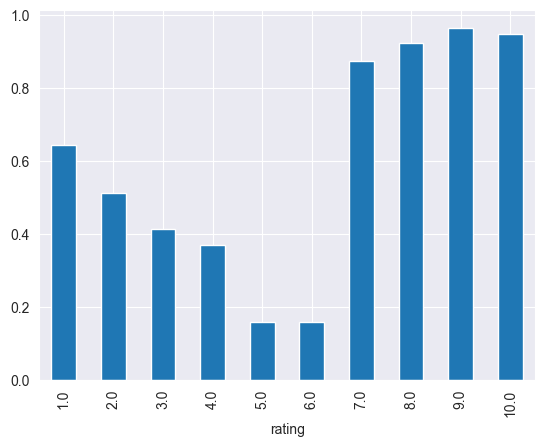

In [64]:
agreement_by_rating = vader_df.groupby('rating')['match'].mean()
agreement_by_rating.plot(kind='bar')

### Sentiment - Transformer